# Cahn–Hilliard 方程

算子分裂方法

TODO Add more details

file: [py/cahn_hilliard.py](py/cahn_hilliard.py)

In [ ]:
from firedrake import *
from firedrake.petsc import PETSc
import matplotlib.pyplot as plt

class Bar(ProgressBar):
    suffix = '%(index)s/%(max)s [%(elapsed_td)s/%(eta_td)s]'
    bar_prefix = ' |'
    bar_suffix = '| '
    empty_fill = ' '
    fill = '#'
    color = None

In [ ]:
def u0(x, y):
    return 0.05*cos(2*pi*x)*cos(2*pi*y)

def f_plus(u):
    return u**3

def f_minus(u):
    return u

In [ ]:
opts = PETSc.Options()
degree = opts.getInt('degree', default=1)
N = opts.getInt('N', default=100)
M = opts.getInt('M', default=200)  # M = 1600
tau = opts.getReal('tau', default=1e-4)
epsilon = opts.getReal('epsilon', default=0.05)
periodic = opts.getBool('periodic', default=True)

dt = Constant(tau)

In [ ]:
if periodic:
    filename = 'pvd/test_ch_periodic.pvd'
    mesh = PeriodicRectangleMesh(N, N, 2, 2)
else:
    filename = 'pvd/test_ch_neumann.pvd'
    mesh = RectangleMesh(N, N, 2, 2)

mesh.coordinates.dat.data[:] = mesh.coordinates.dat.data_ro - 1

In [ ]:
V = FunctionSpace(mesh, 'CG', degree)
W = V*V
v, v_test = Function(W), TestFunction(W)
u, w = split(v)
u_test, w_test = split(v_test)

vn = Function(W)
un, wn = vn.subfunctions
un.rename('u')
wn.rename('w')

In [ ]:
t = 0
x, y = SpatialCoordinate(mesh)
un.interpolate(u0(x,y))

Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f9f708475b0>, FiniteElement('Lagrange', triangle, 1), name=None, index=0, component=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', triangle, 1, variant='equispaced'), dim=2, variant='equispaced'), 605)), 1324)

Text(0, 0.5, 'Density')

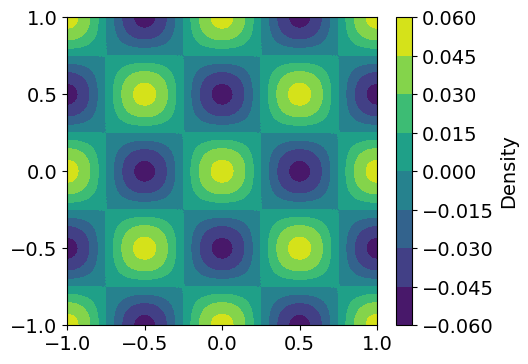

In [ ]:
# plot init value
# colorbar: 
#   https://matplotlib.org/stable/gallery/images_contours_and_fields/contourf_demo.html
fig, ax = plt.subplots(figsize=[5, 4])
cs = tricontourf(un, axes=ax)
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('Density')

定义变分形式和非线性求解器

In [ ]:
a = 1/dt*inner(u - un, u_test)*dx + inner(grad(w), grad(u_test))*dx \
    + inner(w, w_test)*dx - epsilon**2*inner(grad(u), grad(w_test))*dx \
    - inner(f_plus(u) - f_minus(un), w_test)*dx

prob = NonlinearVariationalProblem(a, v)
solver = NonlinearVariationalSolver(prob, options_prefix="ch") #  solver_parameters={'snes_monitor': None, 'snes_view': None})

In [ ]:
PETSc.Sys.Print(f'Will save result in {filename}')
output = File(filename)
output.write(un, wn, time=t)

Will save result in pvd/test_ch_periodic.pvd


时间层循环

In [ ]:
for i in Bar('Timestep').iter(range(M)):
    t = (i+1)*tau
    solver.solve()
    
    vn.assign(v)
    if (i+1)%100 == 0:
        output.write(un, wn, time=t)

Timestep |##################################################| 200/200 [0:00:33/0:00:00]


Text(0.5, 1.0, 'T = 0.02')

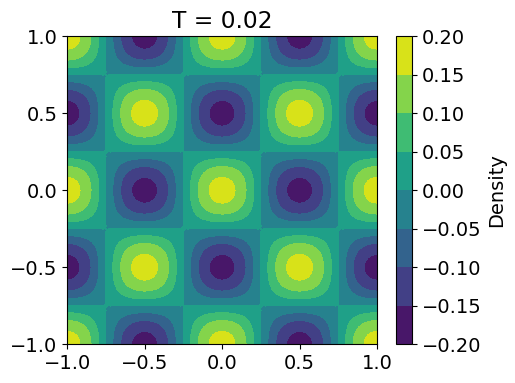

In [ ]:
fig, ax = plt.subplots(figsize=[5, 4])
cs = tricontourf(un, axes=ax)
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('Density')
ax.set_title(f'T = {M*tau}')